## Setup

Load required libraries and configure notebook.

In [1]:
import os
import random
import warnings
import numpy as np
import pandas as pd
from itertools import product
from tqdm.notebook import tqdm
from typing import List, Tuple
from matplotlib import pyplot as plt
from pmdarima.arima.utils import ndiffs


from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tools.sm_exceptions import InterpolationWarning,ConvergenceWarning


from sklearn import set_config
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error


set_config(
    display='diagram',
    transform_output="pandas"
)

warnings.simplefilter('ignore', InterpolationWarning)
warnings.simplefilter('ignore', ConvergenceWarning)

## Load Data

We will load our previously pickled data.

In [2]:
# load data
train_df = pd.read_parquet('./data/train.parquet')
train_df.index = pd.DatetimeIndex(train_df.index).to_period('h')

test_df = pd.read_parquet('./data/test.parquet')
test_df.index = pd.DatetimeIndex(test_df.index).to_period('h')

val_df = pd.read_parquet('./data/val.parquet')
val_df.index = pd.DatetimeIndex(val_df.index).to_period('h')

print(train_df.shape, val_df.shape, test_df.shape)

(24210, 9) (3459, 9) (6918, 9)


## General approach for working with a time series is to:

1. Plotting the series; notice trends and seasonality (we have done this in [`data_preparation.ipynb`](https://github.com/Ibrahim-Ola/time-series-python/blob/main/data_preparation.ipynb)).
2. Detrend the time series by removing the seasonality and drift.
3. Fit the SARIMAX model and calculate the residual.
4. Diagnose the residual.

## SARIMAX

SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) is an advanced statistical model used for forecasting time series data that incorporates both seasonal and non-seasonal components, as well as external or exogenous variables that could influence the time series. It extends the ARIMA model by adding seasonality (the `S` in SARIMAX) and the ability to model the impact of independent external variables (the `X` in SARIMAX), making it highly versatile and powerful for handling complex forecasting scenarios. SARIMAX can be decomposed into:

* S: Seasonal

* AR: Autoregressive (p)

* I: Integrated (d)

* MA: Moving Average (q)

* X: Exogeneous variables

### Stationarity test

Stationarity means that the statistical properties of a time series i.e. mean, variance and covariance do not change over time. Many statistical models require the series to be stationary to make effective and precise predictions. The target variable must be stationary in this case. There are two tests commonly used in practice:

1. Augmented Dickey Fuller (“ADF”) test.
2. Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”) test.

### ADF Test

ADF test is used to determine the presence of unit root in the series, and hence helps in understanding if the series is stationary or not. The null and alternate hypothesis of this test are:

$H_0$: the series has a unit root

$H_1$: the series has no unit root

If we fail to reject the null hypothesis, this test may provide evidence that the series is non-stationary. 


### KPSS Test

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

$H_0$: the process is trend stationary

$H_1$: the series has a unit root (series is not stationary)


### Verdict

It is always better to apply both the tests, so that it can be ensured that the series is truly stationary. If the two tests contradict (they arrive at a different conclusion), we have two cases: 

* **Case I**: KPSS indicates non-stationarity and ADF indicates stationarity - The series is difference stationary. Differencing is to be used to make series stationary. The differenced series is checked for stationarity. 

* **Case II**: If ADF indicates non-stationarity and KPSS indicates stationarity, the series is trend stationary. The series must be detrended (via differencing or model fitting) to make it stationary.

* ADF test

In [3]:
full_train=pd.concat([train_df, val_df])

target=full_train.Global_active_power

ad_fuller_result = adfuller(target)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

print(f"{ad_fuller_result[1]} < 0.05 ? {ad_fuller_result[1] < 0.05}")
print("Stationary? ", ad_fuller_result[1] < 0.05)

ADF Statistic: -12.666951970848114
p-value: 1.2687177744246762e-23
1.2687177744246762e-23 < 0.05 ? True
Stationary?  True


* kpss test

In [4]:
kpss_result = kpss(target)

print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')

print(f"{kpss_result[1]} < 0.05 ? {kpss_result[1] < 0.05}")
print("Stationary? ", kpss_result[1] > 0.05)

KPSS Statistic: 1.001301204978454
p-value: 0.01
0.01 < 0.05 ? True
Stationary?  False


Our tests arrive at different conclusions. In this case, ADF indicates stationarity and KPSS indicates non-stationarity. We need to difference to make our series stationary.

* How many number of differences is required?

In [5]:
n_kpss = ndiffs(target, test='kpss')
print(f'Number of differencing required: {n_kpss}')

Number of differencing required: 1


We only need on differencing to make our series stationary. Hence, no seasonal differencing is required.

In [6]:
## apply 1st-order differencing
target_diff = np.diff(target, n=1)

# Test for stationarity

# ADF Test

ad_fuller_result = adfuller(target_diff)

print(f'ADF Statistic: {ad_fuller_result[0]}')
print(f'p-value: {ad_fuller_result[1]}')

print(f"{ad_fuller_result[1]} < 0.05 ? {ad_fuller_result[1] < 0.05}")


# KPSS Test

kpss_result = kpss(target_diff)

print(f'\nKPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')

print(f"{kpss_result[1]} < 0.05 ? {kpss_result[1] < 0.05}")

ADF Statistic: -37.97005525323006
p-value: 0.0
0.0 < 0.05 ? True

KPSS Statistic: 0.013676524685657172
p-value: 0.1
0.1 < 0.05 ? False


Both tests now agree. Let's investigate the ACF and PACF plots for hints on the the appropriate lags.

## Plotting ACF and PACF functions


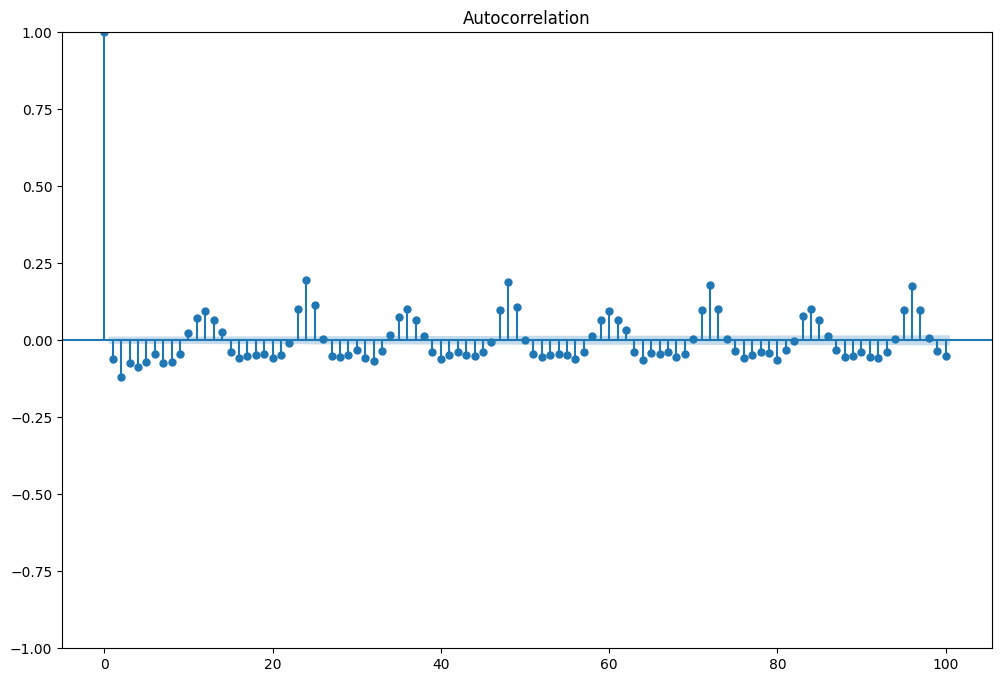

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_acf(target_diff, lags=100, ax=ax)
plt.show()

Our ACF is sinusoidal. When we see a sinusoidal pattern in the ACF plot of a stationary process, this is a hint that an autoregressive process is at play, and we must use an AR(p) model to produce our forecast. However, we will have to plot the partial autocorrelation function and see at which lag the coefficients suddenly become non-significant. This lag will be our `p` in AR(p). We also see clear peaks at lags 24, 48, 72, etc, and lags 12, 24, 34, etc. This also confirms our seasonality claims. 

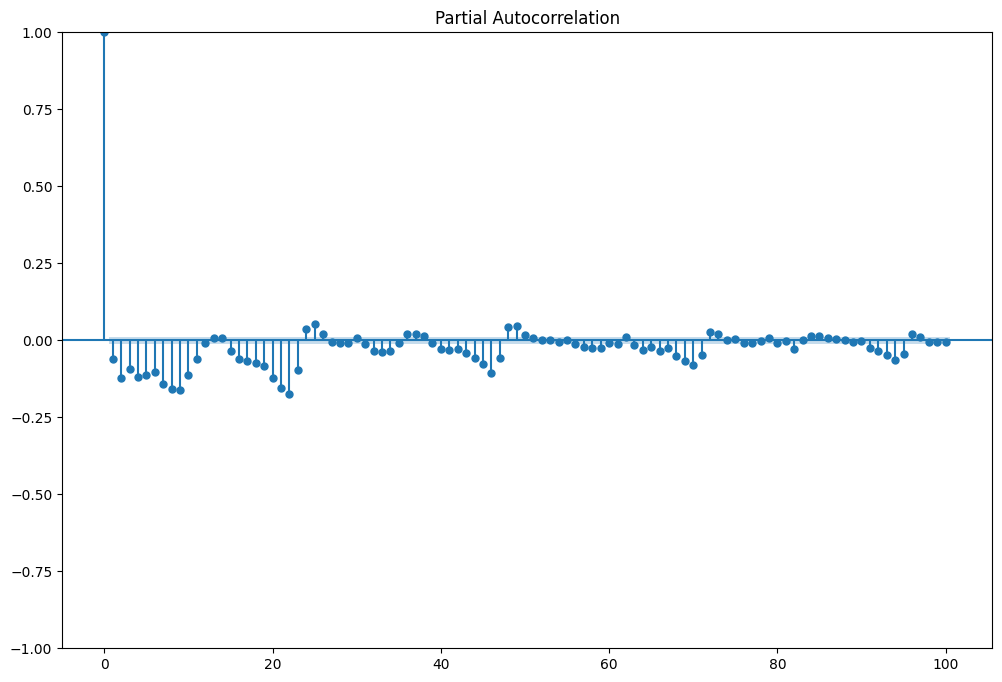

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
plot_pacf(target_diff, lags=100, ax=ax)
plt.show()

The PACF plot is also sinusoidal. This indicates no order for the MA(q) or AR(p) process that can be inferred. We are probably in the presence of an SARMA process.

We will list different possible values of p, Q, q and Q (positive integers). With a list of possible values, we can fit every unique combination of $SARIMA(p,d,q)(P,D,Q)_m$  to our data. Once that’s done, we can compute the Akaike Information Criterion (AIC). The model with the lowest AIC is then selected. You can think of this as hyperparameter optimization in Machine Learning. Note that because we did not do a seasonal diffenece to make our series stationary, the D component of our SARIMA will be 0. In essense, our model is:

$$SARIMA(p,d,q)(P,D,Q)_m = SARIMA(p,1,q)(P,0,Q)_{24}$$ 

I will randomly select 10 combinations so that the model runs for a reasonable time.

In [9]:
def sarimax_randomized_grid_search(
        train_y: pd.Series,
        train_X: pd.DataFrame,
        order_list: List[Tuple[int, int, int, int]],
        n_iter: int = 25,
        d: int = 0,
        D: int = 0,
        s: int = 24,  # Seasonal period, defaulting to 24
        random_state: int = None  # Optional random state for reproducibility
) -> pd.DataFrame:
    """
    Perform a randomized grid search over SARIMAX hyperparameters, including both non-seasonal and seasonal differencing terms,
    the seasonal period, and an optional random state for reproducibility, on the provided training data.
    
    Parameters
    ----------
    train_y : pd.Series
        The response variable for the SARIMAX model.
    train_X : pd.DataFrame
        Explanatory variables for the SARIMAX model.
    order_list : List[Tuple[int, int, int, int]]
        A list of tuples representing the combinations of 'p', 'q', 'P', and 'Q' to search over.
    n_iter : int
        The number of parameter combinations to try from the order_list.
    d : int
        The degree of non-seasonal differencing.
    D : int
        The degree of seasonal differencing.
    s : int
        The seasonal period of the model, with a default of 24.
    random_state : int, optional
        The seed for the random number generator. If None, the random state is not fixed.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing the parameter combination ('p', 'd', 'q', 'P', 'D', 'Q', 's') and the corresponding AIC value.
    """

    if random_state is not None:
        random.seed(random_state)  # Set random state for reproducibility if specified
    
    sampled_order_list = random.sample(order_list, min(len(order_list), n_iter))  # Sample parameter combinations

    results = []

    for order in tqdm(sampled_order_list, desc="Fitting Models"):
        try:
            model = SARIMAX(
                endog=train_y, 
                exog=train_X,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                trend='c'
            )
            model_fit = model.fit(disp=0)

            aic = model_fit.aic
            results.append({
                'order': (order[0], d, order[1], order[2], D, order[3], s),
                'AIC': aic
            })

        except Exception as e:
            print(f"Error with order {order}: {e}")
            continue

    results_df = pd.DataFrame(results).sort_values(by="AIC", ascending=True)

    return results_df


In [42]:
p = range(0, 3, 1)
q = range(0, 3, 1)
P = range(0, 3, 1)
Q = range(0, 3, 1)

parameters = product(p, q, P, Q)
parameters_list = list(parameters)


train_exo, train_endo=full_train.drop(['Global_active_power', 'day_sin', 'day_cos'], axis=1), full_train[['Global_active_power']]
test_exo, test_endo=test_df.drop(['Global_active_power', 'day_sin', 'day_cos'], axis=1), test_df[['Global_active_power']]

sarimax_results = sarimax_randomized_grid_search(
    train_y=train_endo,
    train_X=train_exo,
    order_list=parameters_list,
    n_iter=10,
    d=1,
    D=0,
    random_state=42
)

Fitting Models:   0%|          | 0/10 [00:00<?, ?it/s]

## Model Selection

Let's select the best model using AIC - model with the least AIC is preferred.

In [43]:
sarimax_results

,order,AIC
7,"(2, 1, 1, 2, 0, 0, 24)",80490.807502
5,"(0, 1, 1, 2, 0, 2, 24)",81878.256733
6,"(0, 1, 1, 1, 0, 1, 24)",82072.136602
0,"(0, 1, 1, 1, 0, 2, 24)",82076.841882
8,"(0, 1, 1, 0, 0, 2, 24)",82254.454157
9,"(2, 1, 0, 0, 0, 0, 24)",82721.079849
2,"(1, 1, 0, 2, 0, 2, 24)",83642.975739
3,"(1, 1, 0, 1, 0, 1, 24)",83665.289346
4,"(1, 1, 0, 0, 0, 1, 24)",83674.456862
1,"(0, 1, 0, 1, 0, 0, 24)",85994.547170


Best model based on AIC is:

$$SARIMAX(2,1,1)(2,0,0)_{24}$$ 

In [44]:
## create results directory

os.makedirs('./results', exist_ok=True)

sarimax_results.sort_values('AIC').to_csv('./results/sarimax_randomized_grid_search_results.csv', index=False)

## Fit the final Model

In [45]:
best_order = sarimax_results.iloc[0, 0]
non_seasonal_order = best_order[:3]
seasonal_order = best_order[-4:-1]
seasonl_period = best_order[-1]
print("==========================================")
print(f"Best order: SARIMAX{non_seasonal_order}{seasonal_order}_[{seasonl_period}]")
print("==========================================\n")


final_model = SARIMAX(
    endog=train_endo,
    exog=train_exo,
    order=non_seasonal_order,
    seasonal_order=(*seasonal_order, seasonl_period),
    trend='c'
).fit(disp=0)
print(final_model.summary())

Best order: SARIMAX(2, 1, 1)(2, 0, 0)_[24]

                                      SARIMAX Results                                      
Dep. Variable:                 Global_active_power   No. Observations:                27669
Model:             SARIMAX(2, 1, 1)x(2, 0, [], 24)   Log Likelihood              -40232.404
Date:                             Tue, 05 Mar 2024   AIC                          80490.808
Time:                                     14:34:55   BIC                          80597.772
Sample:                                 12-16-2006   HQIC                         80525.261
                                      - 02-11-2010                                         
Covariance Type:                               opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept                -0.0009      0.

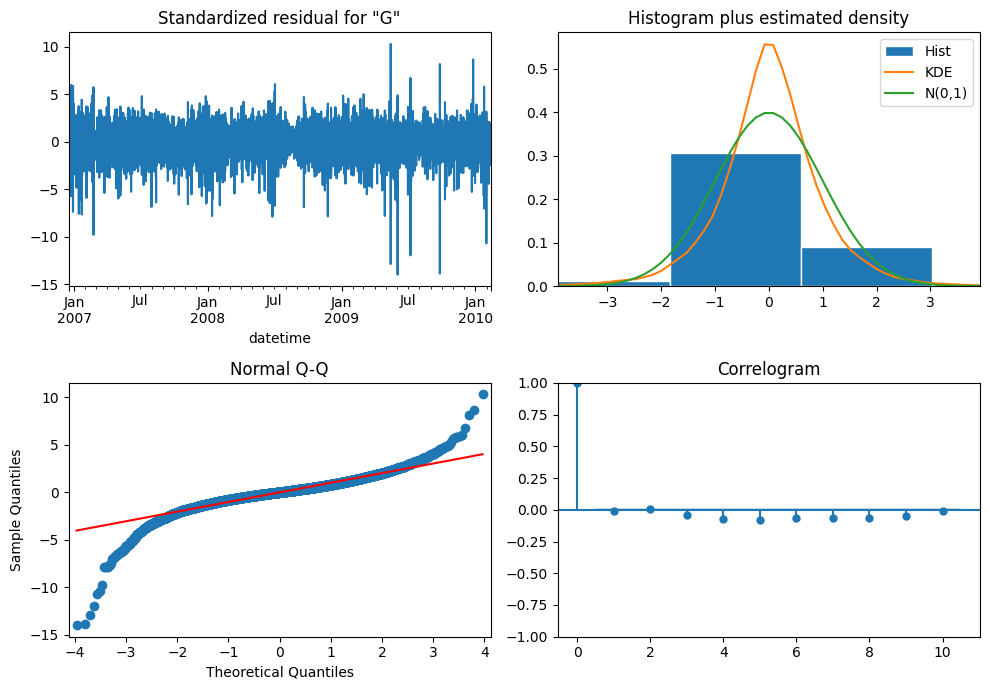

In [50]:
final_model.plot_diagnostics(figsize=(10, 7))
plt.tight_layout()
plt.show()

## Model Diagnostics (Checking Assumptions)

We will now examine the residuals of our fitted model. When using a statistical model for time series analysis, some assumptions must be made about the residuals. In most time series models, the residuals are the difference between the observed and the predicted values.  A good forecasting model should yield residuals with the following property:

1. **The residuals are independent**: the residuals of a good forecasting model should not be autocorrelated. This assumption can be tested using the Ljung-Box test. The Ljung-Box test assesses the null hypothesis that a series of residuals exhibits no autocorrelation for a fixed number of lags  against the alternative that the some autocorrelation coefficient $\rho(l), l=1, 2, \cdots, L$ is nonzero.

2. **The residuals averages to zero**: The residuals of a good time series model must have a mean of zero. otherwise, it is biased.


If these assumptions are not satisfied, then the forecasting model can be improved to give a better forecast. Correcting for bias is straightforward: if the mean of the residuals is `m`, then by adding `m` to all predictions, the issue of bias can be resolved. Fixing autocorrelated residuals problem is a bit harder and beyon the scope of this project. However, for interested readers, see [Dynamic Regression Models](https://otexts.com/fpp2/dynamic.html).

There are two more desired (but not necessary) assumptions:

1. The residuals should be homoskedastic.
2. The residials are normally distributed.

These assumptions makes the computation of prediction intervals easier. A model violating the last two assumptions can not necessarily be improved. Sometimes, log or Box-Cox transformation may help. However, in other cases, there is usually a little you can do if your model violate these assumptions. Instead, other approaches for computing prediction intervals must be explored. 

Alternatively, we can defer to Machine Learning (ML) techniques that do not make any assumption about residuals.

In [57]:
## let's check assumptions

print(f"Mean of residuals: {final_model.resid.mean():.2f}")

Mean of residuals: 0.00


1. **Independent residual**: The model output contains the Ljung-Box test result. The p-value for this test is displayed as Prob(Q). The returned Ljung-Box test a p-value of 0.24. Since $0.24 > 0.05$, we do not reject the null hypothesis and conclude that our series of residuals exhibits no autocorrelation. Assumption met ✅.

2. **Zero Residual Mean**: Our residuals have zero mean. Assumption met ✅.
3. **Normality of Residuals**: The model output contains the normality of residuals test result. The p-value is displayed as Prob(JB). Since $0.00 < 0.05$, we reject the null hypothesis and conclude that our series of residuals is not normally distributed. Assumption not met ❌.
4. **Homoskedastic Residual Assumption**: The model output also contains the homoskedasticity test result.  The p-value is displayed as Prob(H) (two-sided). Since $0.00 < 0.05$, we reject the null hypothesis and conclude that our series of residuals is heteroskedastic. Assumption not met ❌.

The important assumptions were met, so we will use the model for forecasting.

## Forecasting

When forecasting with the SARIMAX model, it's important to consider a significant limitation, especially when incorporating external variables. While these variables can enhance the model's performance, they introduce challenges for long-term forecasting. To predict future values of our target variable over multiple time steps, we must also predict the future values of these external predictors. Since all forecasts inherently contain some level of error, the need to forecast these exogenous variables can amplify the overall prediction error for our target variable. Consequently, as we extend our forecasts further into the future, the accuracy of our predictions may deteriorate more rapidly. This compounding of errors underscores the complexity of using SARIMAX for long-range forecasting when it relies on external predictors.


Assuming that the future values of the exogeneous variables are known, let's evaluate our model performance:

In [127]:
forecast = final_model.get_forecast(steps=len(test_endo), exog=test_exo)
forecast_values=forecast.predicted_mean

print("Performamce on test set:\n========================")
print(f"RMSE: {root_mean_squared_error(test_endo, forecast_values):.3f}")
print(f"R2: {r2_score(test_endo, forecast_values):.3f}")
print(f"MAE: {mean_absolute_error(test_endo, forecast_values):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(test_endo, forecast_values):.3f}")

Performamce on test set:
RMSE: 5.004
R2: 0.987
MAE: 4.297
MAPE: 0.116


In an ideal situation, we usually do not know the future value of our exogeneous variables. As with any model with predictios, in order to obtain forecasts we first need to forecast the predictors. When the predictors are known into the future (e.g., calendar-related variables such as time, day-of-week, etc.), this is straightforward. But when the predictors are themselves unknown, we must either model them separately, or use assumed future values for each predictor.

In this case we used the available future value. You can follow the same steps as we have followed to model the predictors in this case, as a univariate time series. Otherwise, we have built a very good model **provided that the future values of the predictors are known**.

## Plot of Forecast and Confidence Intervals

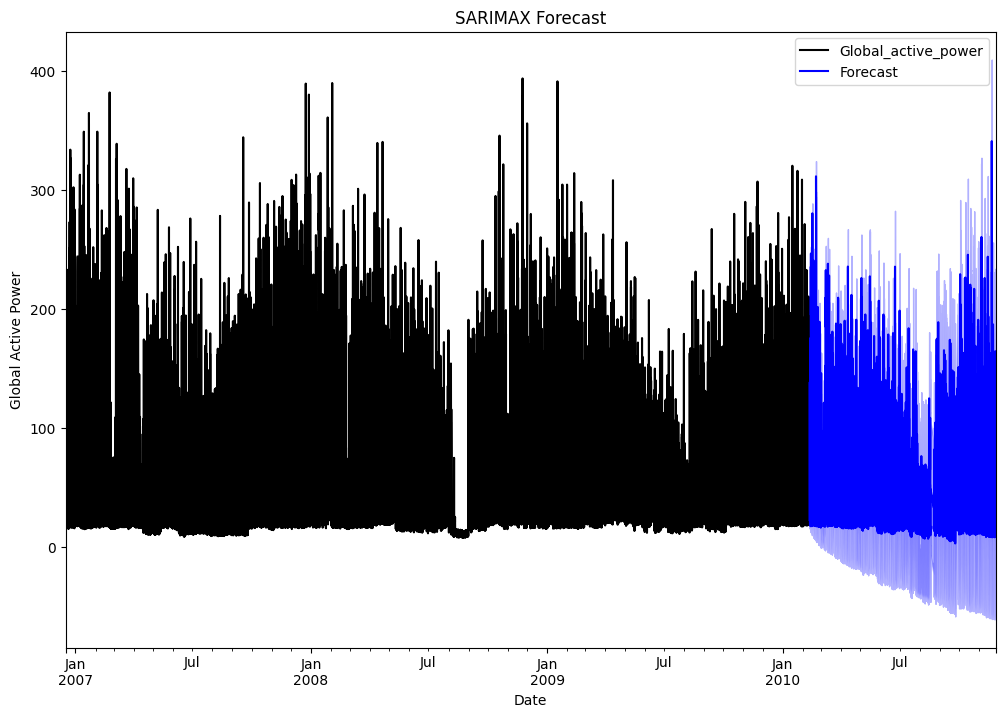

In [104]:
forecast_ci = forecast.conf_int()

fig, ax = plt.subplots(figsize=(12, 8))

# Plot the training data

train_endo.plot(ax=ax, label='Observed', color='black')

# Plot the forecasted values

forecast.predicted_mean.plot(ax=ax, label='Forecast', color='blue')

# Plot the range for the confidence intervals

ax.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:, 0],
    forecast_ci.iloc[:, 1], color='blue', alpha=0.3
)

# Annotate the plot
plt.title('SARIMAX Forecast')
plt.xlabel('Date')
plt.ylabel('Global Active Power')
plt.legend()

plt.show()

## What if the future values of the predictors are unknown?


As mentioned above, there is no straight forward solution, you must use your knowledge about the data and your expertise as a data scientist to inform your decision. Here are a few recommendations if the future value of your predictors is unknown:

1. Use a univariate time series (you can follow all steps outlined above) for target only or to forecast the future values of the predictors.
2. You may use the last known value: you can use the last known value for your forecast, wait until you have a new value and use that for forecast.

Again, this is not a one-size fit all situation and your expertise is needed. Now, let's explore the second option.


In [156]:
new_test_exo=pd.concat([train_exo.iloc[-24:], test_exo.shift(24).dropna()]).reset_index(drop=True)
new_pred=final_model.get_forecast(steps=len(new_test_exo), exog=new_test_exo).predicted_mean

print("Performamce on test set:\n========================")
print(f"RMSE: {root_mean_squared_error(test_endo, new_pred):.3f}")
print(f"R2: {r2_score(test_endo, new_pred):.3f}")
print(f"MAE: {mean_absolute_error(test_endo, new_pred):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(test_endo, new_pred):.3f}")


Performamce on test set:
RMSE: 46.992
R2: -0.156
MAE: 32.135
MAPE: 0.667


There was a massive reduction in model performance. $R^2$ reduced to -0.156 from 0.987. One way to mitigate is you can retrain your model before using it for prediction. Let's see that in action.

In [13]:
non_seasonal_order, seasonal_order, seasonl_period =(2, 1, 1), (2, 0, 0), 24

In [62]:
def set_index_from_list(df, idx):
    df.index = idx
    return df

new_train_endo=train_endo.iloc[24:,]

new_train_exo=(
    train_exo.shift(24)
    .dropna()
    .reset_index(drop=True)
    .pipe(set_index_from_list, new_train_endo.index)
)

new_train_exo.head()

,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,
2006-12-17 18:00,4.802,14074.81,936.0,0.0,403.0,1012.0
2006-12-17 19:00,5.114,13993.95,870.2,0.0,86.0,1001.0
2006-12-17 20:00,4.506,14044.29,835.0,0.0,0.0,1007.0
2006-12-17 21:00,4.600,14229.52,782.8,0.0,25.0,1033.0
2006-12-17 22:00,3.370,14325.60,571.4,0.0,8.0,266.0


In [65]:
model2 = SARIMAX(
    endog=new_train_endo,
    exog=new_train_exo,
    order=non_seasonal_order,
    seasonal_order=(*seasonal_order, seasonl_period),
    trend='c'
).fit(disp=0)
print(model2.summary())

                                      SARIMAX Results                                      
Dep. Variable:                 Global_active_power   No. Observations:                27645
Model:             SARIMAX(2, 1, 1)x(2, 0, [], 24)   Log Likelihood             -138337.528
Date:                             Wed, 06 Mar 2024   AIC                         276701.056
Time:                                     17:21:38   BIC                         276808.009
Sample:                                 12-17-2006   HQIC                        276735.507
                                      - 02-11-2010                                         
Covariance Type:                               opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept                -0.0014      0.003     -0.430      0.667      -0.008       

In [67]:
pred2=model2.get_forecast(steps=len(new_test_exo), exog=new_test_exo).predicted_mean

print("Performamce on test set:\n========================")
print(f"RMSE: {root_mean_squared_error(test_endo, pred2):.3f}")
print(f"R2: {r2_score(test_endo, pred2):.3f}")
print(f"MAE: {mean_absolute_error(test_endo, pred2):.3f}")
print(f"MAPE: {mean_absolute_percentage_error(test_endo, pred2):.3f}")

Performamce on test set:
RMSE: 40.278
R2: 0.151
MAE: 30.497
MAPE: 0.784


Although the assumptions were not met, we made some improvements. We might even get better forecast results if we tune $p, d, q, P, D, \text{and } Q$ to the new data. One other thing we might do is to refit the model using the observed data (predictors and target) every 24 hours before making a forecast if the computing resources are available. Once again, your expertise and knowledge about the data should inform your decision.

## Final Thoughts


* SARIMAX is ideal when the future value of the predictors can be easily inferred/predicted.
* In cases where the future value of the predictors cannot be easily inferred/predicted, your expertise and knowledge about the data are needed.
* I suggest comparing different model performances and selecting the best model for your use case.

## Next Steps

Moving forward, we will build ML models and compare our model performace before selecting the best model.

## References/Further Reading

1. [Time Series Forecasting in Python by Marco Peixeiro](https://www.manning.com/books/time-series-forecasting-in-python-book).
2. [Forecasting: Principles and Practice Rob J Hyndman and George Athanasopoulos](https://otexts.com/fpp2/).